In [ ]:
##This block is only for access of files using google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import cv2;
import matplotlib.pyplot as plt

import numpy as np;
from random import shuffle;
import cv2;
from random import shuffle;
from tqdm import tqdm;
import tensorflow;
from tensorflow.keras import layers;
from tensorflow.keras import Model;
from tensorflow.keras.optimizers import SGD;


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
train_Data_File = drive.CreateFile({'id': '11UzJtoYiSvlIfUmXB__BnAcAJKqosiV8'});
train_Data_File.GetContentFile('Nerve_Segmentation_Data.zip');

In [ ]:
!unzip 'Nerve_Segmentation_Data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: 34_114_mask.tif         
  inflating: 34_115.tif              
  inflating: 34_115_mask.tif         
  inflating: 34_116.tif              
  inflating: 34_116_mask.tif         
  inflating: 34_117.tif              
  inflating: 34_117_mask.tif         
  inflating: 34_118.tif              
  inflating: 34_118_mask.tif         
  inflating: 34_119.tif              
  inflating: 34_119_mask.tif         
  inflating: 34_11_mask.tif          
  inflating: 34_12.tif               
  inflating: 34_12_mask.tif          
  inflating: 34_13.tif               
  inflating: 34_13_mask.tif          
  inflating: 34_14.tif               
  inflating: 34_14_mask.tif          
  inflating: 34_15.tif               
  inflating: 34_15_mask.tif          
  inflating: 34_16.tif               
  inflating: 34_16_mask.tif          
  inflating: 34_17.tif               
  inflating: 34_17_mask.tif          
  inflating: 34_18.tif               

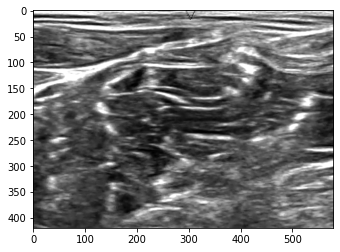

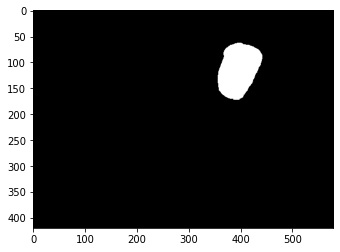

In [ ]:
from PIL import Image
im = np.array(Image.open("34_31.tif"))
im_mask = np.array(Image.open("34_31_mask.tif"))
plt.imshow(im, cmap='gray')
plt.show()
plt.imshow(im_mask, cmap='gray')

In [ ]:
#Resizing the images and masks and normalizing

import glob
from tqdm import tqdm;
ImSize = 140;
image_Array = np.zeros((len(glob.glob("*_mask.tif")),ImSize, ImSize))
mask_Array = np.zeros((len(glob.glob("*_mask.tif")),ImSize, ImSize))
file_Names = set();
count = 0;
for file in tqdm(glob.glob("*_mask.tif")):
  f_Name = file.split("_mask.tif")[0]
  file_Names.add(f_Name)
  I = np.array(Image.open(f_Name+".tif").resize((ImSize,ImSize)));
  image_Array[count,:,:] = I/255;
  I = np.array(Image.open(f_Name+"_mask.tif").resize((ImSize,ImSize)));
  mask_Array[count,:,:] = I/255;
  count = count+1;

100%|██████████| 5635/5635 [00:54<00:00, 103.23it/s]


**Question:**


Accurately identifying nerve structures in ultrasound images is a critical step in effectively inserting a patient’s pain management catheter. In this you are challenged to build a model that can identify nerve structures in a dataset of ultrasound images of the neck. Doing so would improve catheter placement and contribute to a more pain free future. 

The task in this competition is to segment a collection of nerves called the Brachial Plexus (BP) in ultrasound images. You are provided with a large training set of images where the nerve has been manually annotated by humans. Annotators were trained by experts and instructed to annotate images where they felt confident about the existence of the BP landmark.

Make an autoencoder model to perform automatic segmentation of the BP in ultrasound images.

In [ ]:
IMAGE_SIZE = 140;
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K

input_img = Input(shape=( IMAGE_SIZE, IMAGE_SIZE, 1))  # adapt this if using `channels_first` image data format


x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(4, (3, 3), activation='relu', padding='same')(x)



x = UpSampling2D((2, 2))(encoded)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)



autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()
print(encoded.shape)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 140, 140, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 140, 140, 16)      160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 70, 70, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 70, 70, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 35, 35, 4)         292       
Total params: 1,612
Trainable params: 1,612
Non-trainable params: 0
_________________________________________________________

In [ ]:
encoded_input = Input(shape = (35,35,4))
decoder_layer_start_number = -4

#Extract decoder layers from autoencoder
decoder_layer1 = autoencoder.layers[-4]
decoder_layer2 = autoencoder.layers[-3]
decoder_layer3 = autoencoder.layers[-2]
decoder_layer4 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input)))))
decoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 35, 35, 4)]       0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 70, 70, 4)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 70, 70, 8)         296       
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 140, 140, 8)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 140, 140, 1)       73        
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.fit(image_Array,mask_Array,
                epochs=50,
                batch_size=256,
                shuffle=True)

Epoch 1/50
23/23 [==============================] - 36s 213ms/step - loss: 0.6911
Epoch 2/50
23/23 [==============================] - 5s 206ms/step - loss: 0.5519
Epoch 3/50
23/23 [==============================] - 5s 204ms/step - loss: 0.1088
Epoch 4/50
23/23 [==============================] - 5s 205ms/step - loss: 0.1007
Epoch 5/50
23/23 [==============================] - 5s 206ms/step - loss: 0.0932
Epoch 6/50
23/23 [==============================] - 5s 205ms/step - loss: 0.0838
Epoch 7/50
23/23 [==============================] - 5s 205ms/step - loss: 0.0767
Epoch 8/50
23/23 [==============================] - 5s 205ms/step - loss: 0.0724
Epoch 9/50
23/23 [==============================] - 5s 205ms/step - loss: 0.0717
Epoch 10/50
23/23 [==============================] - 5s 207ms/step - loss: 0.0681
Epoch 11/50
23/23 [==============================] - 5s 207ms/step - loss: 0.0659
Epoch 12/50
23/23 [==============================] - 5s 206ms/step - loss: 0.0632
Epoch 13/50
23/23 [=====

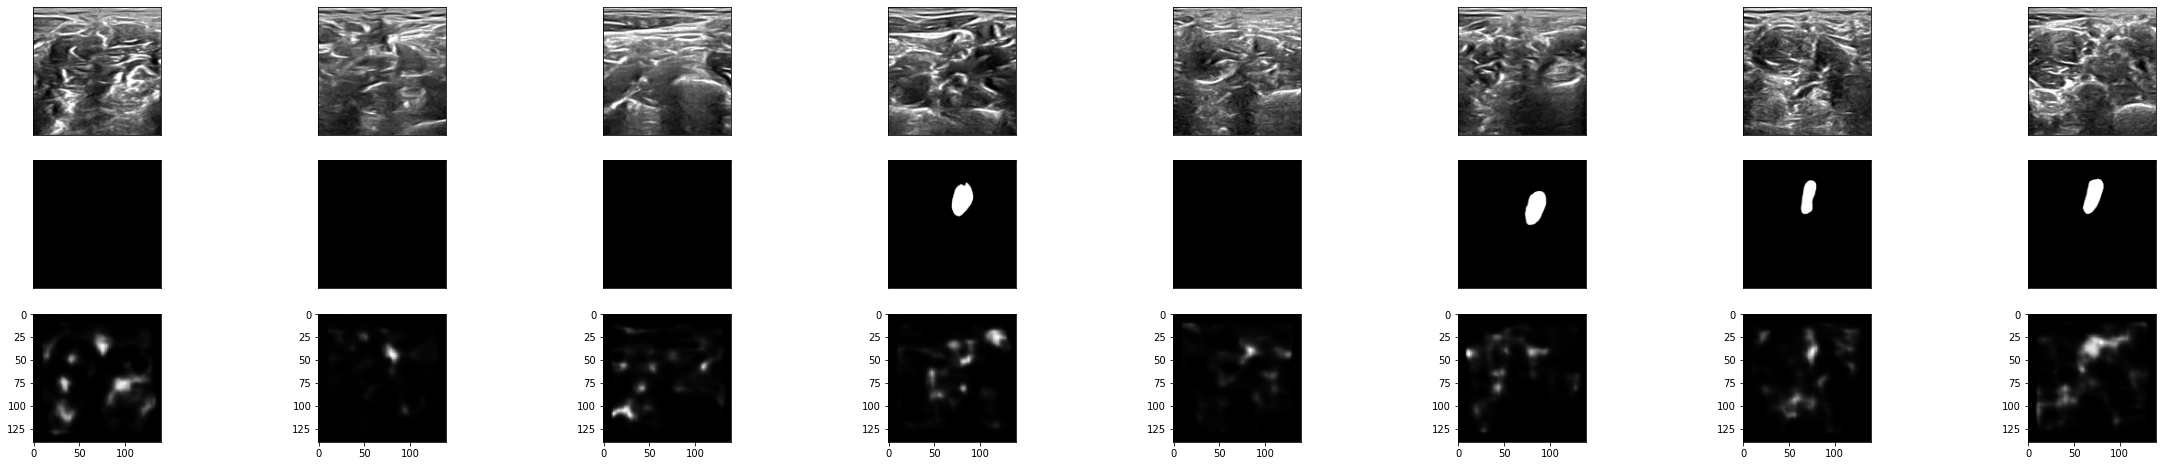

In [ ]:
import matplotlib.pyplot as plt
decoded_imgs = autoencoder.predict(image_Array)

n = 8
plt.figure(figsize=(40, 8))
for i in range(n):
    images = plt.subplot(3, n, i+1)
    plt.imshow(image_Array[i].reshape(IMAGE_SIZE,IMAGE_SIZE))
    plt.gray()
    images.get_xaxis().set_visible(False)
    images.get_yaxis().set_visible(False)


    images = plt.subplot(3, n, i+1+n)
    plt.imshow(mask_Array[i].reshape(IMAGE_SIZE,IMAGE_SIZE))
    plt.gray()
    images.get_xaxis().set_visible(False)
    images.get_yaxis().set_visible(False)


    ax = plt.subplot(3, n, i + 1+2*n)
    plt.imshow(decoded_imgs[i].reshape(IMAGE_SIZE, IMAGE_SIZE))
    plt.gray()
    images.get_xaxis().set_visible(False)
    images.get_yaxis().set_visible(False)
plt.show()